In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math as math
import cv2
import random

# Segmentation par seuillage de l’histogramme

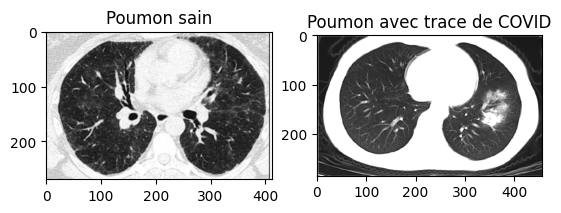

In [ ]:
imgPoumonSain = Image.open('CT_NonCOVID.jpg')
imgPoumonSain_gris = np.array(imgPoumonSain.convert("L"))
imgPoumonCOVID = Image.open('CT_COVID (3).png')
imgPoumonCOVID_gris = np.array(imgPoumonCOVID.convert("L"))

plt.subplot(1,2,1)
plt.imshow(imgPoumonSain_gris, cmap='gray')
plt.title("Poumon sain")

plt.subplot(1,2,2)
plt.imshow(imgPoumonCOVID_gris, cmap='gray')
plt.title("Poumon avec trace de COVID")

plt.show()

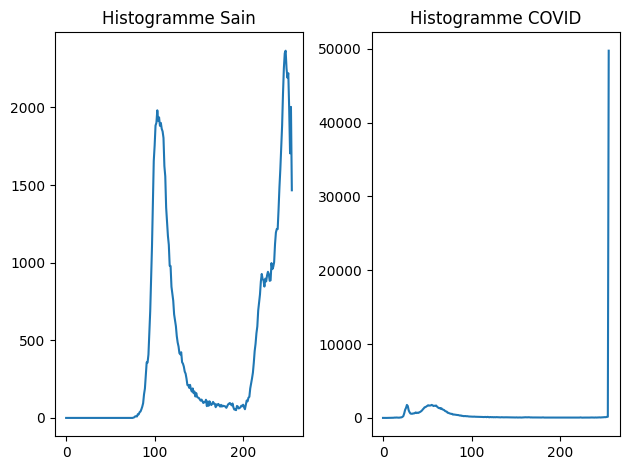

In [ ]:
histogramSain = np.histogram(imgPoumonSain_gris, bins=256, range=(0, 256))[0]
histogramCOVID = np.histogram(imgPoumonCOVID_gris, bins=256, range=(0, 256))[0]

plt.subplot(1, 2, 1)
plt.plot(histogramSain)
plt.title("Histogramme Sain")

plt.subplot(1, 2, 2)
plt.plot(histogramCOVID)
plt.title("Histogramme COVID")

plt.tight_layout()
plt.show()

# Segmentation par Kmeans

In [ ]:
def algo_seuillage(img, seuil):
  S1, S2 = 0, 255
  img_seuillee = np.zeros((len(img), len(img[0])))

  for i in range(len(img)):
      for j in range(len(img[0])):
          if img[i][j] < seuil:
              img_seuillee[i][j] = S1
          else:
              img_seuillee[i][j] = S2

  return img_seuillee

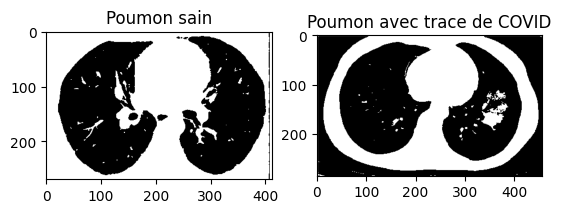

In [ ]:
imgSeuilleeSain = algo_seuillage(imgPoumonSain_gris, 180)
imgSeuilleeCOVID = algo_seuillage(imgPoumonCOVID_gris, 180)


plt.subplot(1,2,1)
plt.imshow(imgSeuilleeSain, cmap='gray')
plt.title("Poumon sain")

plt.subplot(1,2,2)
plt.imshow(imgSeuilleeCOVID, cmap='gray')
plt.title("Poumon avec trace de COVID")

plt.show()

In [ ]:
def k_means(img, K):

    max_iter = 100
    cpt = 0

    # définir les centres initiaux
    centres = []
    for i in range(K):
        centres.append(random.randint(0, 255))
    # ranger les centres dans l'ordre croissant
    centres.sort()

    # tant que les centres changent
    while True:

        cpt += 1

        centres_old = centres.copy()

        # Affecter pour chaque intensité i allant de 0 à 255 de l’histogramme, la classe ayant la moyenne la plus proche de cette intensité	i
        classes = []
        for i in range(K):
            classes.append([])
        for i in range(len(img)):
            for j in range(len(img[0])):
                distance = 255
                classe = 0
                for k in range(K):
                    if abs(img[i][j] - centres[k]) < distance:
                        distance = abs(img[i][j] - centres[k])
                        classe = k
                classes[classe].append(img[i][j])

        # Calculer les nouvelles moyennes de chaque classe
        for i in range(K):
            if len(classes[i]) != 0:
                centres[i] = sum(classes[i]) / len(classes[i])

        # Condition de convergence
        if centres_old == centres or cpt == max_iter:
            break

    # on construit l'image seuillée
    img_seuillee = np.zeros((len(img), len(img[0])))
    for i in range(len(img)):
        for j in range(len(img[0])):
            distance = 255
            classe = 0
            for k in range(K):
                if abs(img[i][j] - centres[k]) < distance:
                    distance = abs(img[i][j] - centres[k])
                    classe = k
            img_seuillee[i][j] = centres[classe]

    return img_seuillee


In [ ]:
imgKmeansSain = k_means(imgPoumonSain_gris, 4)
imgKmeansCOVID = k_means(imgPoumonCOVID_gris, 4)

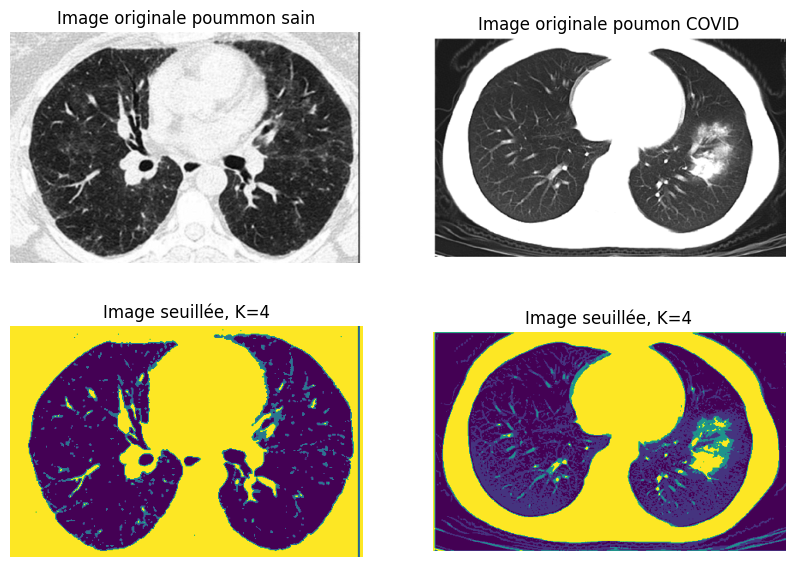

In [ ]:
# affichage
plt.figure(figsize=(10, 7))

plt.subplot(221)
plt.axis('off')
plt.title("Image originale poummon sain")
plt.imshow(imgPoumonSain_gris, cmap='gray')

plt.subplot(222)
plt.axis('off')
plt.title("Image originale poumon COVID")
plt.imshow(imgPoumonCOVID_gris, cmap='gray')

plt.subplot(223)
plt.axis('off')
plt.title("Image seuillée, K=4")
plt.imshow(imgKmeansSain)

plt.subplot(224)
plt.axis('off')
plt.title("Image seuillée, K=4")
plt.imshow(imgKmeansCOVID)

plt.show()

In [ ]:
def segmentation_image(image):
  # Appliquer le seuillage d'Otsu pour la segmentation
  _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  # Trouver les régions connectées
  _, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

  # Créer une image de couleur blanche
  colored_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

  # Générer des couleurs uniques pour chaque région
  region_colors = []
  for _ in range(stats.shape[0]):
      region_colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

  # Colorer chaque région segmentée
  for i in range(1, stats.shape[0]):
      mask = labels == i
      colored_image[mask] = region_colors[i]

  return colored_image

In [ ]:
imgPoumonSain_colored = segmentation_image(imgPoumonSain_gris)
imgPoumonCOVID_colored = segmentation_image(imgPoumonCOVID_gris)

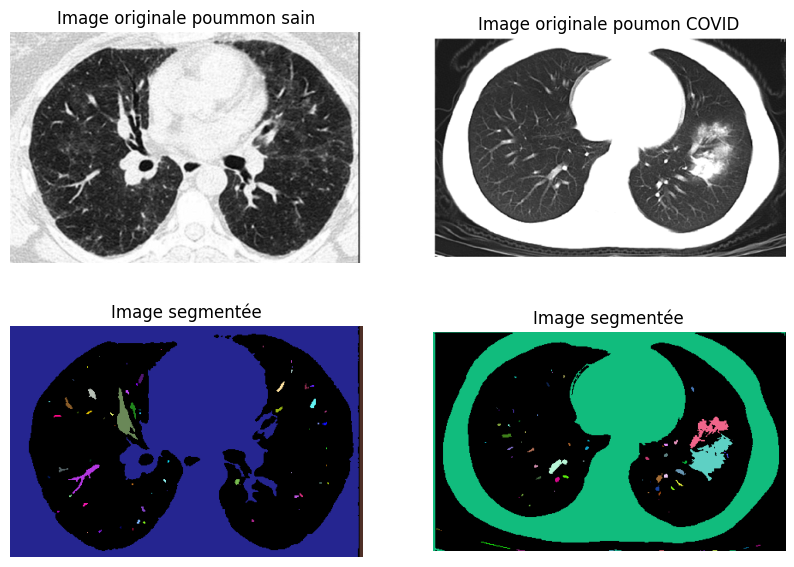

In [ ]:
# affichage
plt.figure(figsize=(10, 7))

plt.subplot(221)
plt.axis('off')
plt.title("Image originale poummon sain")
plt.imshow(imgPoumonSain_gris, cmap='gray')

plt.subplot(222)
plt.axis('off')
plt.title("Image originale poumon COVID")
plt.imshow(imgPoumonCOVID_gris, cmap='gray')

plt.subplot(223)
plt.axis('off')
plt.title("Image segmentée")
plt.imshow(imgPoumonSain_colored)

plt.subplot(224)
plt.axis('off')
plt.title("Image segmentée")
plt.imshow(imgPoumonCOVID_colored)

plt.show()

In [ ]:
def pseudo_labellisation(image):
    # Appliquer le seuillage d'Otsu pour la segmentation
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Trouver les régions connectées
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

    # Trier les régions par leur superficie (aire) en ordre décroissant
    regions_sorted_by_area = sorted(range(1, len(stats)), key=lambda k: stats[k, cv2.CC_STAT_AREA], reverse=True)

    # Créer une image de couleur blanche
    colored_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    # Sélectionner et colorer seulement le troisième plus imposant élément
    if len(regions_sorted_by_area) >= 3 :
        third_largest_region_index = regions_sorted_by_area[1]
        mask = labels == third_largest_region_index
        colored_image[mask] = (255, 0, 0)
        third_largest_region_index = regions_sorted_by_area[2]
        mask = labels == third_largest_region_index
        colored_image[mask] = (255, 0, 0)
        # Couleur blanche pour la troisième plus grande région

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if colored_image[i][j][0] != 255 or colored_image[i][j][1] != 0 or colored_image[i][j][2] != 0:
                colored_image[i][j] = image[i][j]

    return colored_image

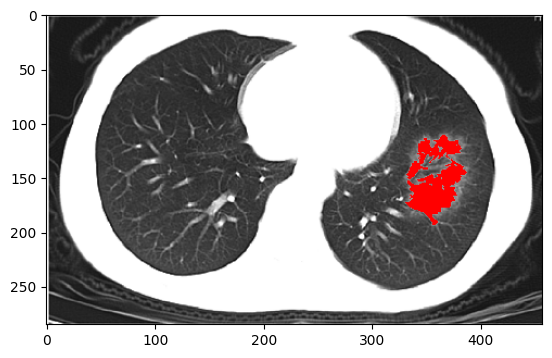

In [ ]:
imgPoumonCOVID_colored = pseudo_labellisation(imgPoumonCOVID_gris)

plt.imshow(imgPoumonCOVID_colored)

plt.show()

# Architecture du modèle de classification

In [ ]:
!pip install torch torchvision

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm

# Charger un modèle Res2Net pré-entraîné (par exemple, Res2Net-50)
res2net = timm.create_model('res2net50_26w_4s', pretrained=True)

# Remplacer la dernière couche (classification) par Global Average Pooling
res2net.avgpool = nn.AdaptiveAvgPool2d(1)

# Ajouter une couche entièrement connectée avec deux canaux distincts pour chaque classe
num_classes = 2  # Pour la classification binaire
res2net.fc = nn.Sequential(
    nn.Linear(2048, 1024),  # 2048 est la taille de l'entière sortie de Res2Net
    nn.ReLU(),
    nn.Linear(1024, num_classes * 2)  # num_classes est 2 pour la classification binaire
)

# Afficher la structure du modèle
print(res2net)

model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottle2neck(
      (conv1): Conv2d(64, 104, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(26, 26, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bns): ModuleList(
        (0-2): 3 x BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (pool): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (conv3): Conv2d(104, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_run

# Architecture du modèle de segmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# Fonction pour créer un bloc de convolution double
def double_conv_layer(x, filters, kernel_size=(3, 3), activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding='same')(x)
    conv = Conv2D(filters, kernel_size, activation=activation, padding='same')(conv)
    return conv

# Fonction pour créer l'encodeur basé sur VGG-16
def vgg16_encoder(input_tensor):
    from tensorflow.keras.applications.vgg16 import VGG16
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    # Supprimer les couches supérieures pour obtenir l'encodeur
    encoder = Model(inputs=vgg16.input, outputs=vgg16.get_layer('block5_conv3').output)
    return encoder

# Fonction pour créer le décodeur avec Attentive Feature Fusion
def attentive_feature_fusion(decoder, encoder_output, filters, upsample_size=(2, 2)):
    upsampled_decoder = UpSampling2D(size=upsample_size)(decoder)
    attention = Conv2D(filters, (1, 1), activation='sigmoid')(upsampled_decoder)
    multiplied = tf.keras.layers.Multiply()([upsampled_decoder, attention])
    concatenated = Concatenate()([multiplied, encoder_output])
    return concatenated

# Création du modèle U-Net-like
def create_unet_vgg16(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encodeur basé sur VGG-16
    encoder = vgg16_encoder(inputs)

    # Ajouter des couches de décodeur avec Attentive Feature Fusion
    decoder_block1 = attentive_feature_fusion(encoder, encoder.get_layer('block4_conv3').output, 512)
    decoder_block2 = attentive_feature_fusion(decoder_block1, encoder.get_layer('block3_conv3').output, 256)
    decoder_block3 = attentive_feature_fusion(decoder_block2, encoder.get_layer('block2_conv2').output, 128)
    decoder_block4 = attentive_feature_fusion(decoder_block3, encoder.get_layer('block1_conv2').output, 64)


    # Couche de sortie
    output = Conv2D(num_classes, (1, 1), activation='softmax')(decoder_block4)

    model = Model(inputs=inputs, outputs=output)

    return model
